## An example of Gaussian smoothing for 3D grids data in Fourier space.

### import python library
There is a bug so you must import Utils (something related to the Fourier transform) first!

In [1]:
from CosmAna import Utils # must import this line first
from mpi4py import MPI
import numpy as np
from CosmAna import MPI_IO 

In [2]:
import matplotlib.pyplot as plt

### Toy data
Here, I create a toy data and used it to show how the `CosmAna` work when smoothing density field.

In [3]:
Ng = 32 # grids number per side
L = 300. # boxsize
data = np.zeros([Ng, Ng, Ng], dtype=np.float32)
pos = np.array([[Ng / 2, Ng / 2, Ng / 2],                   # set 4 particles position
                [Ng / 2 + 4, Ng / 2 - 3, Ng / 2 + 1],
                [2, 1, 1],                      
                [-1, -1, Ng / 2]])
for i, j, k in pos:                                         # assign particles into grids
    data[i, j, k] += 1

show the toy data in three direction

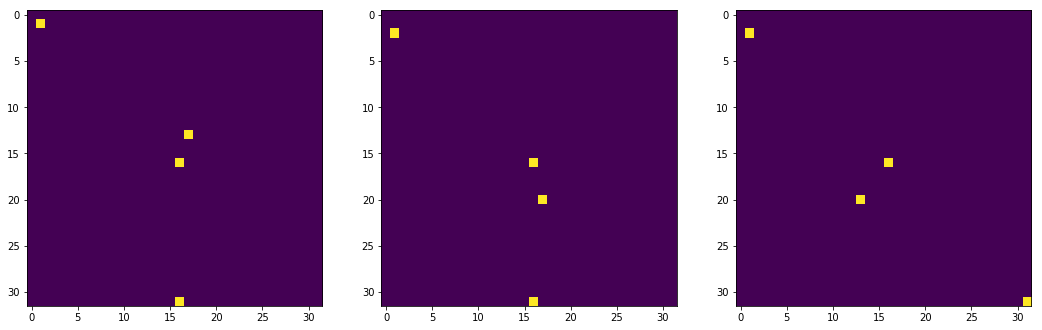

In [4]:
fig, ax = plt.subplots(figsize=[18,6],nrows=1, ncols=3)
ax[0].imshow(data.mean(axis=0))
ax[1].imshow(data.mean(axis=1))
ax[2].imshow(data.mean(axis=2))

### MPI IO
In `CosmAna`, there is a library named `MPI_IO`, which can be used to read or write binary data (C order) in parallel. The follow is an example to save and read the toy data.

- first, create a instance of the `Utils` class and don't care its output

In [5]:
utils = Utils(L=L, Ng=Ng)

parameters:
N: 32, L: 300.000000


- Then, create a instance of the `MPI_IO`

In [6]:
mpi_io = MPI_IO(comm=utils.comm, MPI=utils.MPI)

- set file path

In [7]:
path = '/tmp/test.bin'

- Write data. The 3D field will be saved like `[(x0,y0,z0),(x0,y0,z1),(x0,y0,z2)...]`
or in C code:
```
for i in axis0:
    for j in axis1:
        for k in axis2:
            write data[i,j,k]
```

In [8]:
mpi_io.dataw = data.copy(order='C')
mpi_io.MPI_WRITE(path)

In [9]:
!ls -lth /tmp/test.bin

-rw-r--r-- 1 mtx mtx 128K Mar  6 11:31 /tmp/test.bin


- read it again. To do it, you should create a empty array first to allocate memory. After reading it, the data is saved in `mpi_io.datar` array, and its shape is [Ng*3]. You can reshape it to get original data shape [Ng,Ng,Ng]

In [10]:
mpi_io.datar = np.empty(shape=[Ng * Ng * Ng / utils.size], dtype=np.float32)
mpi_io.MPI_READ(path=path)

- check it

In [11]:
data2 = mpi_io.datar.reshape([Ng,Ng,Ng])
print np.allclose(data, data2)

True


### Gaussian Smoothing

In [12]:
sigma = 15.

If you readdata by `MPI_IO`, you can use it directly. Otherwise, you should split the 3D array by the number of processes in the first axis, like:
```
data_mpi = np.array_split(data1, utils.comm.size)[utils.comm.rank]
```

In [13]:
datas = utils.Smooth(data, sigma)

`datas` is the smoothed field

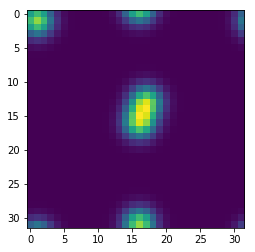

In [14]:
plt.imshow(datas.mean(axis=0))

### check the result by Gaussian smoothing in real space

In [15]:
def GaussInRealSpace(x, pos, sigma):
    H = utils.H
    Ng = utils.Ng
    zeros = np.zeros([Ng, Ng, Ng], dtype=np.float32)
    x = np.arange(Ng, dtype=np.float32)[:, None, None] + zeros
    y = np.arange(Ng, dtype=np.float32)[None, :, None] + zeros
    z = np.arange(Ng, dtype=np.float32)[None, None, :] + zeros
    for i, j, k in pos:
        dx = x - i
        dy = y - j
        dz = z - k
        dx[dx > Ng / 2] -= Ng
        dx[dx < -Ng / 2] += Ng
        dy[dy > Ng / 2] -= Ng
        dy[dy < -Ng / 2] += Ng
        dz[dz > Ng / 2] -= Ng
        dz[dz < -Ng / 2] += Ng
        dis = dx**2. + dy**2. + dz**2.
        w = 1. / np.sqrt(2. * np.pi * sigma**2.) * \
            np.exp(-0.5 * dis * H**2. / (sigma**2.))
        w /= w.sum()
        zeros += w
    return zeros

In [16]:
data_real = GaussInRealSpace(data, pos, sigma)

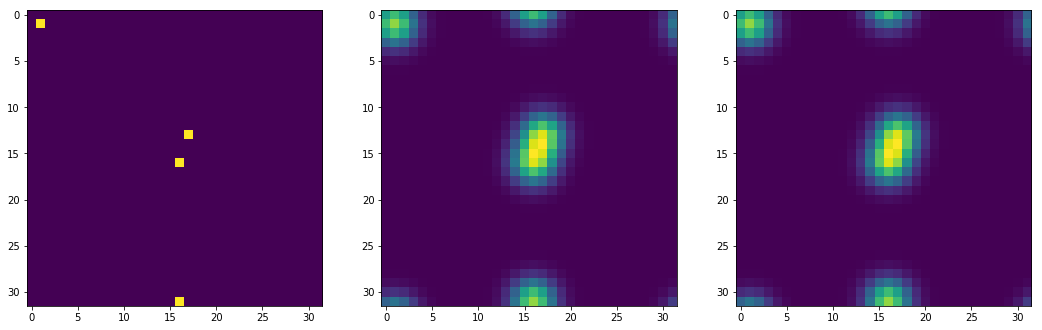

In [17]:
fig, ax = plt.subplots(figsize=[18,6],nrows=1, ncols=3)
ax[0].imshow(data.mean(axis=0))
ax[1].imshow(datas.mean(axis=0))
ax[2].imshow(data_real.mean(axis=0))

In [18]:
print np.allclose(datas,data_real)

True


## MPI run

The above is an example for smoothing density in one process. The MPI script version is [this one](https://github.com/POFK/CosmAna/blob/master/CosmAna/exam/exam_smooth.py)
You can run this file by 
```
mpirun -np 4 python exam_smooth.py
```